# Data Scientist Professional Practical Exam Submission

Tasty Bytes, an online search engine for recipes and meal plan subscription provider, has asked our data science team to help them predict which recipes, when posted to the site's home page, lead to high website traffic. 

According to the Product Manager of Recipe Discovery, traffic to other parts of the website can go up by as much as 40% if a popular recipe is picked, leading to more subscriptions and thus the success of the business.

We have been tasked with two main objectives: 
1) To predict which recipes will lead to high traffic, and 
2) To correctly predict high traffic recipes 80% of the time

In order to tackle these objectives, I will take the following steps:
- Data cleaning and validation
- Exploratory analysis with data visualization
- Pre-processing the data for modeling
- Model Fitting
- Model Evaluation

## Data Cleaning and Validation
It is important to validate all variables and clean the data to make it ready for further analysis. This includes checking for missing values, validating data types, and finding outliers. 

In [28]:
# Importing necessary libraries for data importing and validation
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

# Reading in data and turning recipe number into index
recipes = pd.read_csv('recipe_site_traffic_2212.csv', index_col='recipe')

# Inspecting first five rows of data to make sure it was imported correctly
display(recipes.head())

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,High
2,35.48,38.56,0.66,0.92,Potato,4,High
3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
4,97.03,30.56,38.63,0.02,Beverages,4,High
5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [29]:
# Find and count number of missing values by column, count total number of observations in the data set
display(recipes.isna().sum())
display(len(recipes))

calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

947

We have 947 instances in this data set, with 52 missing values each in the calories, carbohydrate, sugar, and protein columns, and 373 missing values in the high_traffic column.

It's possible that the 52 missing values across calories, carbohydrates, sugar, and protein are for the same rows. In that case, those rows are not very useful because they contain too much missing data. I will try dropping any rows that have missing values for all four of these columns, and see if that takes care of the issue.

In [30]:
recipes.dropna(how='all', subset=['calories', 'carbohydrate', 'sugar', 'protein'], inplace=True)
display(recipes.isna().sum())
display(len(recipes))

calories          0
carbohydrate      0
sugar             0
protein           0
category          0
servings          0
high_traffic    360
dtype: int64

895

The dropna() function dropped 52 observations (947-895), and all of the 52 missing values for calories, carbohydrate, sugar, and protein columns disappeared, which is what we were hoping for. The high_traffic column has missing values for any recipes that did not get high traffic, so we will just need to convert those to boolean 0's. 

Let's take a look at the data types of the columns, and make sure that they align with the brief and allow us to do the proper analyses on them.

In [31]:
# Checking data types to make sure they match what was in the brief 
display(recipes.dtypes)

# Replace a servings values with just their numeric value to keep categories consistent
recipes['servings'] = recipes['servings'].replace('4 as a snack', '4')
recipes['servings'] = recipes['servings'].replace('6 as a snack', '6')

# Convert high_traffic to boolean type by filling null values with False, and replacing values equal to 'High' with True
recipes['high_traffic'] = recipes['high_traffic'].fillna(value=False)
recipes['high_traffic'] = recipes['high_traffic'].replace('High', True)
recipes['high_traffic'] = recipes['high_traffic'].astype('bool')

# Checking if category column matches the options given in the project brief
display(recipes['category'].value_counts())

# Replacing 'Chicken Breast' option with just 'Chicken'
recipes['category'] = recipes['category'].replace('Chicken Breast', 'Chicken')

# Convert category and servings columns to dummy variables, so we can use them later with sci-kit learn
category_dummies = pd.get_dummies(recipes['category'], drop_first = True)
servings_dummies = pd.get_dummies(recipes['servings'], drop_first = True)
recipes = pd.concat([recipes, category_dummies, servings_dummies], axis=1)
recipes = recipes.rename(columns = {'One Dish Meal': 'One_Dish_Meal', '2': '2_servings', '4': '4_servings', '6':'6_servings'})
display(recipes.dtypes)
display(recipes)

calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

Breakfast         106
Chicken Breast     94
Beverages          92
Potato             83
Lunch/Snacks       82
Vegetable          78
Dessert            77
Meat               74
Pork               73
Chicken            69
One Dish Meal      67
Name: category, dtype: int64

calories         float64
carbohydrate     float64
sugar            float64
protein          float64
category          object
servings          object
high_traffic        bool
Breakfast          uint8
Chicken            uint8
Dessert            uint8
Lunch/Snacks       uint8
Meat               uint8
One_Dish_Meal      uint8
Pork               uint8
Potato             uint8
Vegetable          uint8
2_servings         uint8
4_servings         uint8
6_servings         uint8
dtype: object

,calories,carbohydrate,sugar,protein,category,servings,high_traffic,Breakfast,Chicken,Dessert,Lunch/Snacks,Meat,One_Dish_Meal,Pork,Potato,Vegetable,2_servings,4_servings,6_servings
recipe,,,,,,,,,,,,,,,,,,,
2,35.48,38.56,0.66,0.92,Potato,4,True,0,0,0,0,0,0,0,1,0,0,1,0
3,914.28,42.68,3.09,2.88,Breakfast,1,False,1,0,0,0,0,0,0,0,0,0,0,0
4,97.03,30.56,38.63,0.02,Beverages,4,True,0,0,0,0,0,0,0,0,0,0,1,0
5,27.05,1.85,0.80,0.53,Beverages,4,False,0,0,0,0,0,0,0,0,0,0,1,0
6,691.15,3.46,1.65,53.93,One Dish Meal,2,True,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,186.21,83.94,1.98,22.40,Chicken,4,True,0,1,0,0,0,0,0,0,0,0,1,0
943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,False,0,0,0,1,0,0,0,0,0,1,0,0
945,951.74,29.42,3.57,13.87,Pork,2,True,0,0,0,0,0,0,1,0,0,1,0,0


So far, we have dealt with missing values and validated the data types of the columns. Now let's take a look at some summary statistics and visualizations for the data to try to identify outliers and any skewness. 

,calories,carbohydrate,sugar,protein,Breakfast,Chicken,Dessert,Lunch/Snacks,Meat,One_Dish_Meal,Pork,Potato,Vegetable,2_servings,4_servings,6_servings
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.00000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296,0.118436,0.182123,0.086034,0.09162,0.082682,0.074860,0.081564,0.092737,0.087151,0.194413,0.410056,0.206704
std,453.020997,43.949032,14.679176,36.369739,0.323304,0.386162,0.280570,0.28865,0.275554,0.263313,0.273853,0.290226,0.282214,0.395970,0.492119,0.405168
min,0.140000,0.030000,0.010000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,110.430000,8.375000,1.690000,3.195000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,288.550000,21.480000,4.550000,10.800000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,597.650000,44.965000,9.800000,30.200000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,3633.160000,530.420000,148.750000,363.360000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


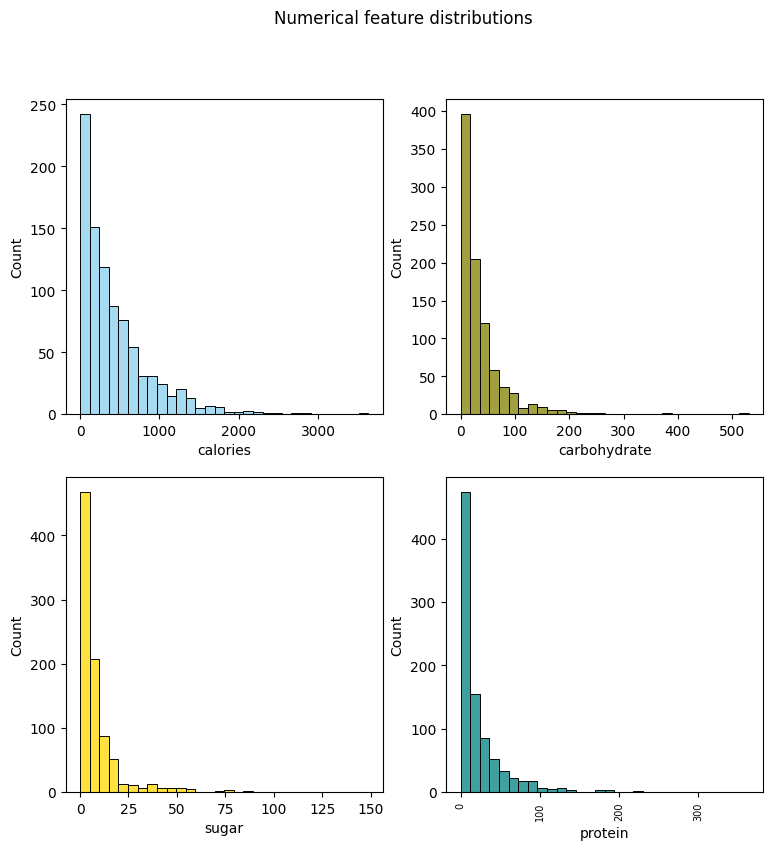

In [32]:
# Summary statistics for each column
display(recipes.describe())

# Visualizing the data column distributions using histograms
fig, axs = plt.subplots(2, 2, figsize=(9,9))
sns.histplot(data=recipes, x="calories", color="skyblue", ax=axs[0, 0], bins=30)
sns.histplot(data=recipes, x="carbohydrate", color="olive", ax=axs[0, 1], bins=30)
sns.histplot(data=recipes, x="sugar", color="gold", ax=axs[1, 0], bins=30)
sns.histplot(data=recipes, x="protein", color="teal", ax=axs[1, 1], bins=30)
plt.xticks(rotation=90,fontsize=7)
plt.suptitle('Numerical feature distributions')
plt.show()

The above plots give us a brief insight into the numeric variables. The calories, carbohydrate, sugar, and protein columns are all right-skewed, and there appear to be quite a number of outliers in the right tail. 

We see supporting information in the descriptive statistics. We can see that the minimum and maximum values of the calories column are nonsensical (0.14 and 3,633.16, respectively). We also see some nonsensical maximum values in the carbohydrate, sugar, and protein columns. For example, the maximum carbohydrate value is 530.42 grams. We know that carbohydrates contain 4 calories per gram, which would lead us to believe that this particular recipe contains at least 2,121.68 calories per serving. However, when we investigate this row of the data, it indicates that this recipe only contains 182.76 calories per serving.

It is likely that these errors are the result of misplaced decimal points. In the above example, the recipe with 530.42 grams of carbohydrates may actually only have 5.3 grams. Because we don't have the ability to communicate with the product manager to talk about how this data was sourced and whether there may be any human or non-human error involved, I will choose to drop observations with outliers in order to maintain the integrity of the dataset. 

In order to identify the outliers, I will transform the data so we can more easily identify outliers in both the left and right tails. Eliminating skewness in data is also beneficial for machine learning because skewness can degrade a model's ability to predict in the less populated areas of the distribution.

I will try a few transformations below to get these columns to look more like normal distributions, before identifying outliers using the IQR method.

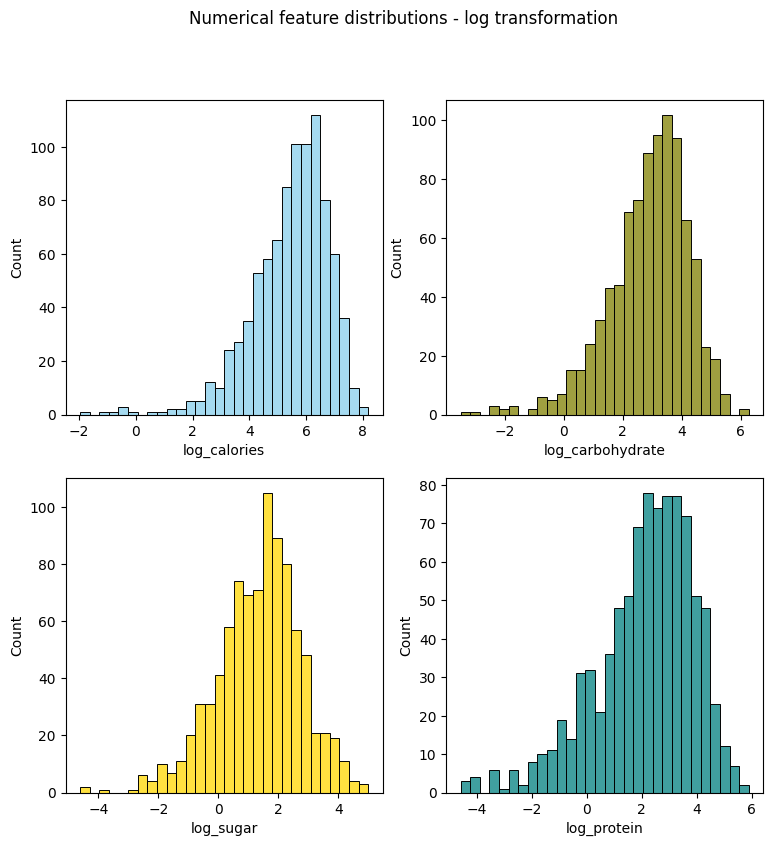

In [33]:
# Trying a log transformation on the data and re-plotting distribution
recipes['log_calories'] = np.log(recipes['calories'])
recipes['log_carbohydrate'] = np.log(recipes['carbohydrate'])
recipes['log_sugar'] = np.log(recipes['sugar'])
recipes['log_protein'] = np.log(recipes['protein'])

fig, axs = plt.subplots(2, 2, figsize=(9,9))
sns.histplot(data=recipes, x="log_calories", color="skyblue", ax=axs[0, 0], bins=30)
sns.histplot(data=recipes, x="log_carbohydrate", color="olive", ax=axs[0, 1], bins=30)
sns.histplot(data=recipes, x="log_sugar", color="gold", ax=axs[1, 0], bins=30)
sns.histplot(data=recipes, x="log_protein", color="teal", ax=axs[1, 1], bins=30)
plt.suptitle('Numerical feature distributions - log transformation')
plt.show()

These distributions are looking more normal, but it looks like the log transformation moved the distributions a little too far to the right and now they are left skewed, which makes it hard to eliminate outliers in the right tail. I will try a few other transformations below.

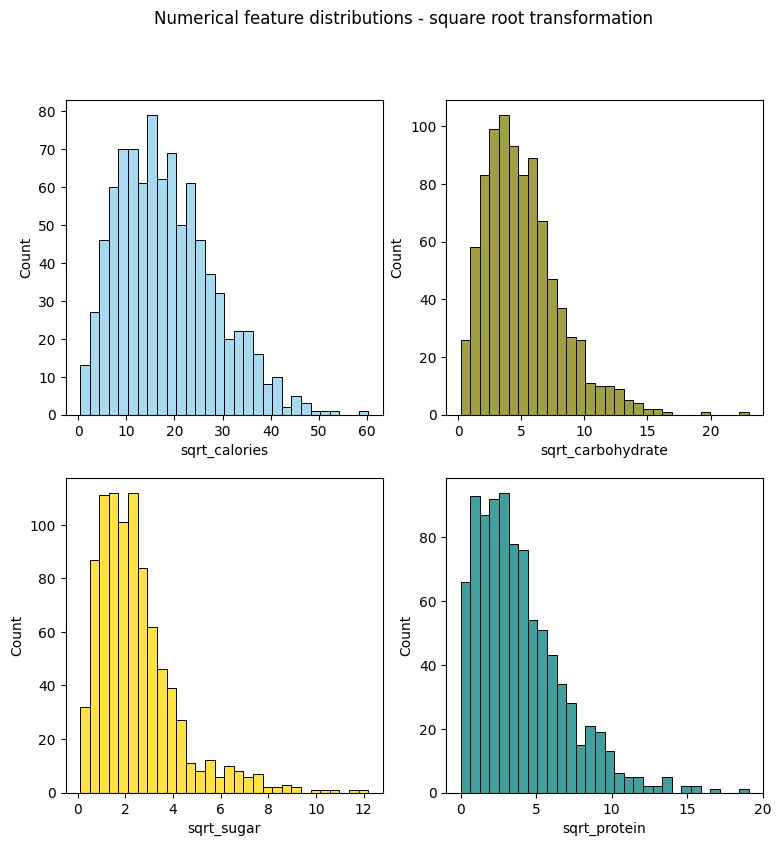

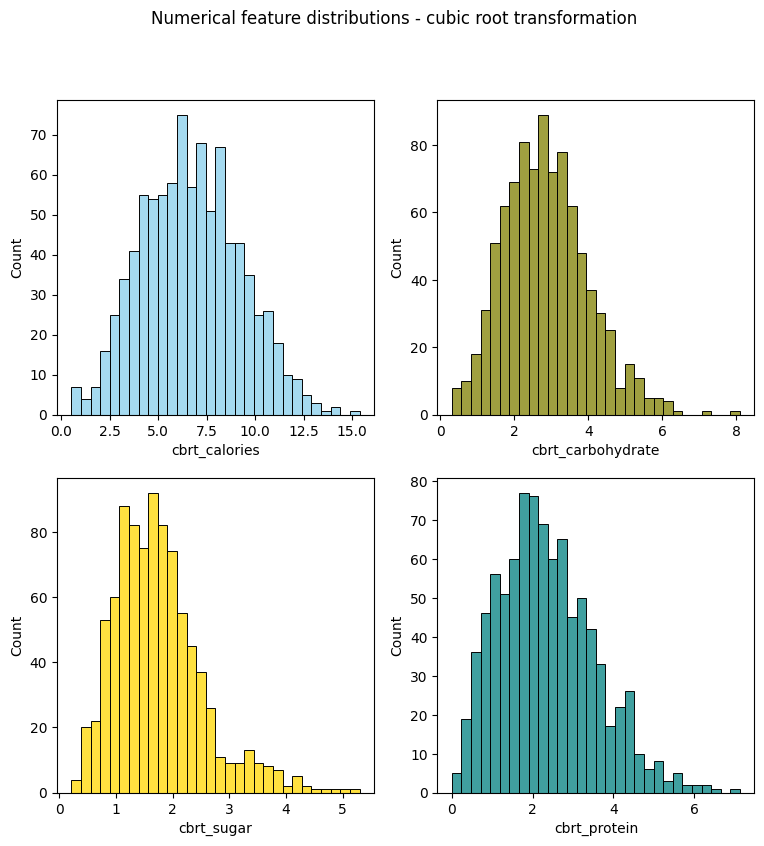

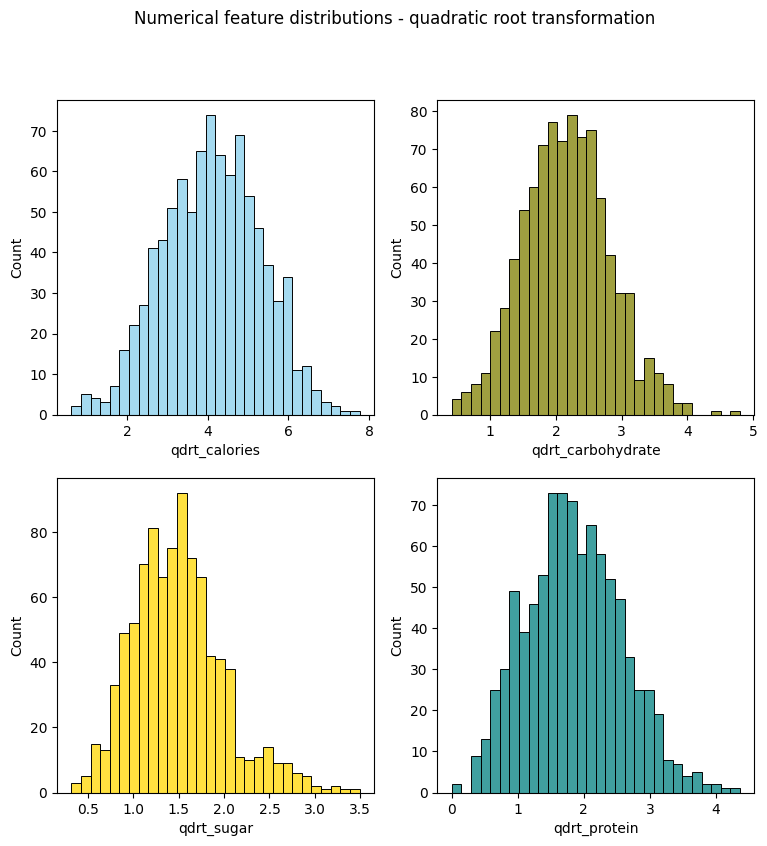

In [34]:
# Trying a square root transformation on the data and re-plotting distribution
recipes['sqrt_calories'] = np.sqrt(recipes['calories'])
recipes['sqrt_carbohydrate'] = np.sqrt(recipes['carbohydrate'])
recipes['sqrt_sugar'] = np.sqrt(recipes['sugar'])
recipes['sqrt_protein'] = np.sqrt(recipes['protein'])

fig, axs = plt.subplots(2, 2, figsize=(9,9))
sns.histplot(data=recipes, x="sqrt_calories", color="skyblue", ax=axs[0, 0], bins=30)
sns.histplot(data=recipes, x="sqrt_carbohydrate", color="olive", ax=axs[0, 1], bins=30)
sns.histplot(data=recipes, x="sqrt_sugar", color="gold", ax=axs[1, 0], bins=30)
sns.histplot(data=recipes, x="sqrt_protein", color="teal", ax=axs[1, 1], bins=30)
plt.suptitle('Numerical feature distributions - square root transformation')
plt.show()

# Trying a cubic root transformation on the data and re-plotting distribution
recipes['cbrt_calories'] = np.cbrt(recipes['calories'])
recipes['cbrt_carbohydrate'] = np.cbrt(recipes['carbohydrate'])
recipes['cbrt_sugar'] = np.cbrt(recipes['sugar'])
recipes['cbrt_protein'] = np.cbrt(recipes['protein'])

fig, axs = plt.subplots(2, 2, figsize=(9,9))
sns.histplot(data=recipes, x="cbrt_calories", color="skyblue", ax=axs[0, 0], bins=30)
sns.histplot(data=recipes, x="cbrt_carbohydrate", color="olive", ax=axs[0, 1], bins=30)
sns.histplot(data=recipes, x="cbrt_sugar", color="gold", ax=axs[1, 0], bins=30)
sns.histplot(data=recipes, x="cbrt_protein", color="teal", ax=axs[1, 1], bins=30)
plt.suptitle('Numerical feature distributions - cubic root transformation')
plt.show()

# Trying a quadratic root transformation on the data and re-plotting distribution
recipes['qdrt_calories'] = np.power(recipes['calories'], 1/4)
recipes['qdrt_carbohydrate'] = np.power(recipes['carbohydrate'], 1/4)
recipes['qdrt_sugar'] = np.power(recipes['sugar'], 1/4)
recipes['qdrt_protein'] = np.power(recipes['protein'], 1/4)

fig, axs = plt.subplots(2, 2, figsize=(9,9))
sns.histplot(data=recipes, x="qdrt_calories", color="skyblue", ax=axs[0, 0], bins=30)
sns.histplot(data=recipes, x="qdrt_carbohydrate", color="olive", ax=axs[0, 1], bins=30)
sns.histplot(data=recipes, x="qdrt_sugar", color="gold", ax=axs[1, 0], bins=30)
sns.histplot(data=recipes, x="qdrt_protein", color="teal", ax=axs[1, 1], bins=30)
plt.suptitle('Numerical feature distributions - quadratic root transformation')
plt.show()


I like the quadratic root transformation here as it spreads out the lower values while still maintaining the right tail as well, which will allow us to identify outliers in both tails. I will go ahead and find the outliers for each column by the recipe category. The reason I decided to sort by category as well is because different types of recipes have different nutritional content. For example, we would expect a dessert recipe to have much more sugar than a vegetable recipe, so 35 grams of sugar may be an outlier for a vegetable recipe, but perfectly normal for a dessert recipe. Similarly, 0 grams of protein might be an outlier for a meat recipe, but within reason for a beverage recipe. I wanted to be able to identify outliers while taking into account the nuances between categories and their different nutritional contents. 

In [35]:
# Initializing empty lists to store our IQR and outlier data
columns = ['qdrt_calories', 'qdrt_carbohydrate', 'qdrt_sugar', 'qdrt_protein']
total_outliers = pd.DataFrame()
columns_Q1 = []
columns_Q3 = []
columns_IQR = []
columns_lower_range = []
columns_upper_range = []

# Identify outliers in each column using IQR method
for column in columns: 
    # Group by category and calculate quartiles and IQR
    category_Q1 = recipes.groupby('category')[column].quantile(0.25)
    category_Q3 = recipes.groupby('category')[column].quantile(0.75)
    category_IQR = category_Q3 - category_Q1
    
    # Calculate lower and upper bounds for each category
    category_lower_range = category_Q1 - (1.5 * category_IQR)
    category_upper_range = category_Q3 + (1.5 * category_IQR)
    
    # Identify outliers in each category and add them to the total_outliers DataFrame
    for category in recipes['category'].unique():
        category_outliers = recipes[(recipes['category'] == category) & ((recipes[column] < category_lower_range[category]) | (recipes[column] > category_upper_range[category]))]
        total_outliers = pd.concat([total_outliers, category_outliers])
    
    # Append quartiles, IQR, and bounds for the column to the corresponding lists
    columns_Q1.append(category_Q1)
    columns_Q3.append(category_Q3)
    columns_IQR.append(category_IQR)
    columns_lower_range.append(category_lower_range)
    columns_upper_range.append(category_upper_range)

# Creating a dataframe containing the stats generated in the for loop
stats = pd.DataFrame({'Q1': columns_Q1, 'Q3': columns_Q3, 'IQR': columns_IQR, 'lower_range': columns_lower_range, 'upper_range': columns_upper_range}, index=columns)
print('IQR statistics by column and category:')
display(stats)

# Display table of instances containing outliers
total_outliers.drop_duplicates(inplace=True)
print('Outliers:')
display(total_outliers.sort_values('qdrt_calories'))

# Because the above outliers only encompass around 2.9% of the dataset, I will just drop them
recipes = recipes.drop(total_outliers.index)


IQR statistics by column and category:


,Q1,Q3,IQR,lower_range,upper_range
qdrt_calories,category Beverages 2.824448 Breakfast ...,category Beverages 4.050229 Breakfast ...,category Beverages 1.225781 Breakfast ...,category Beverages 0.985776 Breakfast ...,category Beverages 5.888900 Breakfast ...
qdrt_carbohydrate,category Beverages 1.363364 Breakfast ...,category Beverages 2.141093 Breakfast ...,category Beverages 0.777729 Breakfast ...,category Beverages 0.196770 Breakfast ...,category Beverages 3.307686 Breakfast ...
qdrt_sugar,category Beverages 1.329799 Breakfast ...,category Beverages 1.998623 Breakfast ...,category Beverages 0.668824 Breakfast ...,category Beverages 0.326563 Breakfast ...,category Beverages 3.001859 Breakfast ...
qdrt_protein,category Beverages 0.619672 Breakfast ...,category Beverages 0.972640 Breakfast ...,category Beverages 0.352967 Breakfast ...,category Beverages 0.090222 Breakfast ...,category Beverages 1.502090 Breakfast ...


Outliers:


,calories,carbohydrate,sugar,protein,category,servings,high_traffic,Breakfast,Chicken,Dessert,Lunch/Snacks,Meat,One_Dish_Meal,Pork,Potato,Vegetable,2_servings,4_servings,6_servings,log_calories,log_carbohydrate,log_sugar,log_protein,sqrt_calories,sqrt_carbohydrate,sqrt_sugar,sqrt_protein,cbrt_calories,cbrt_carbohydrate,cbrt_sugar,cbrt_protein,qdrt_calories,qdrt_carbohydrate,qdrt_sugar,qdrt_protein
recipe,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
501,0.30,5.19,0.96,1.51,Beverages,4,False,0,0,0,0,0,0,0,0,0,0,1,0,-1.203973,1.646734,-0.040822,0.412110,0.547723,2.278157,0.979796,1.228821,0.669433,1.731367,0.986485,1.147252,0.740083,1.509357,0.989846,1.108522
653,0.54,30.59,10.45,0.36,Beverages,6,True,0,0,0,0,0,0,0,0,0,0,0,1,-0.616186,3.420673,2.346602,-1.021651,0.734847,5.530823,3.232646,0.600000,0.814325,3.127470,2.186278,0.711379,0.857232,2.351770,1.797956,0.774597
670,0.80,12.26,1.33,6.21,Chicken,6,False,0,1,0,0,0,0,0,0,0,0,0,1,-0.223144,2.506342,0.285179,1.826161,0.894427,3.501428,1.153256,2.491987,0.928318,2.305845,1.099724,1.838078,0.945742,1.871210,1.073898,1.578603
514,2.98,9.81,28.58,19.11,Chicken,1,False,0,1,0,0,0,0,0,0,0,0,0,0,1.091923,2.283402,3.352707,2.950212,1.726268,3.132092,5.346027,4.371499,1.439037,2.140703,3.057413,2.673541,1.313875,1.769772,2.312148,2.090813
469,27.11,22.63,4.93,0.00,Beverages,1,False,0,0,0,0,0,0,0,0,0,0,0,0,3.299903,3.119276,1.595339,-inf,5.206726,4.757100,2.220360,0.000000,3.004069,2.828535,1.701959,0.000000,2.281825,2.181078,1.490087,0.000000
591,52.08,75.39,49.53,28.37,Pork,6,True,0,0,0,0,0,0,1,0,0,0,0,1,3.952781,4.322675,3.902579,3.345332,7.216647,8.682742,7.037755,5.326350,3.734424,4.224460,3.672452,3.049906,2.686382,2.946649,2.652877,2.307889
848,88.17,49.37,0.01,0.40,Beverages,6,False,0,0,0,0,0,0,0,0,0,0,0,1,4.479267,3.899343,-4.605170,-0.916291,9.389888,7.026379,0.100000,0.632456,4.450823,3.668493,0.215443,0.736806,3.064292,2.650732,0.316228,0.795271
350,94.27,383.06,5.98,39.61,Potato,1,True,0,0,0,0,0,0,0,1,0,0,0,0,4.546163,5.948192,1.788421,3.679082,9.709274,19.571919,2.445404,6.293648,4.551185,7.262547,1.815099,3.408801,3.115971,4.424016,1.563779,2.508714
71,100.00,95.89,10.20,114.60,Lunch/Snacks,4,False,0,0,0,1,0,0,0,0,0,0,1,0,4.605170,4.563202,2.322388,4.741448,10.000000,9.792344,3.193744,10.705139,4.641589,4.577107,2.168703,4.857299,3.162278,3.129272,1.787105,3.271871


There are still recipes remaining in the dataset with less than 50 calories per serving or more than 1500 calories per serving, which are unrealistic unless in very specific circumstances. For example, we can imagine a recipe for a beverage like tea or coffee might contain less than 50 calories, but would not expect a recipe for Chicken or Pork to contain less than 50 calories per serving. Relying on domain knowledge/common sense can make sense in instances where a more methodical approach misses obvious erroneous instances. In this case, I will go ahead and drop observations with less than 50 calories per serving, unless they are in the Beverages, Vegetable, or Breakfast categories, which are the three categories with the lowest mean calories per serving. I will also drop observations with more than 1500 calories per serving. The below will drop an additional 80 observations, for a total of 106 observations dropped, or around 11.8% of the dataset. 

In [36]:
# Mean calories per serving, grouped by category
print('Descriptive statistics by category:')
display(recipes.groupby('category')['calories'].describe())

# Drop observations with less than 50 calories per serving, unless it is a Beverage, Vegetable, or a Breakfast 
recipes_cleaned = recipes[(recipes['calories'] > 50) | (recipes['category'].isin(['Beverages', 'Breakfast', 'Vegetable']))]
# Drop all observations with more than 1500 calories per serving 
recipes_cleaned = recipes_cleaned[recipes_cleaned['calories'] < 1500]

print('Finalized cleaned dataset:')
display(recipes_cleaned)

Descriptive statistics by category:


,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Beverages,88.0,184.491364,161.394596,2.14,68.8925,135.375,274.2650,836.95
Breakfast,104.0,328.538173,341.347261,0.64,61.9200,216.030,494.5850,1724.25
Chicken,158.0,536.621646,485.319716,22.02,208.7125,377.240,659.7950,2508.47
Dessert,75.0,345.299867,302.197974,0.59,102.2900,267.510,536.5550,1588.26
Lunch/Snacks,80.0,488.181000,408.730688,0.14,124.3800,372.595,755.0850,1542.53
Meat,73.0,583.639315,502.670911,5.87,169.8300,454.270,816.2500,1706.75
One Dish Meal,67.0,579.090000,540.991509,13.62,186.8100,419.280,832.8600,2332.32
Pork,72.0,637.730694,625.114834,1.56,159.7150,405.210,957.4575,2906.01
Potato,75.0,418.001333,375.252006,9.26,137.0450,269.460,611.0000,2068.07


Finalized cleaned dataset:


,calories,carbohydrate,sugar,protein,category,servings,high_traffic,Breakfast,Chicken,Dessert,Lunch/Snacks,Meat,One_Dish_Meal,Pork,Potato,Vegetable,2_servings,4_servings,6_servings,log_calories,log_carbohydrate,log_sugar,log_protein,sqrt_calories,sqrt_carbohydrate,sqrt_sugar,sqrt_protein,cbrt_calories,cbrt_carbohydrate,cbrt_sugar,cbrt_protein,qdrt_calories,qdrt_carbohydrate,qdrt_sugar,qdrt_protein
recipe,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,914.28,42.68,3.09,2.88,Breakfast,1,False,1,0,0,0,0,0,0,0,0,0,0,0,6.818137,3.753730,1.128171,1.057790,30.237063,6.532993,1.757840,1.697056,9.705690,3.494686,1.456530,1.422757,5.498824,2.555972,1.325835,1.302711
4,97.03,30.56,38.63,0.02,Beverages,4,True,0,0,0,0,0,0,0,0,0,0,1,0,4.575020,3.419692,3.654029,-3.912023,9.850381,5.528110,6.215304,0.141421,4.595175,3.126447,3.380453,0.271442,3.138532,2.351193,2.493051,0.376060
5,27.05,1.85,0.80,0.53,Beverages,4,False,0,0,0,0,0,0,0,0,0,0,1,0,3.297687,0.615186,-0.223144,-0.634878,5.200961,1.360147,0.894427,0.728011,3.001851,1.227601,0.928318,0.809267,2.280562,1.166253,0.945742,0.853236
6,691.15,3.46,1.65,53.93,One Dish Meal,2,True,0,0,0,0,0,1,0,0,0,1,0,0,6.538357,1.241269,0.500775,3.987687,26.289732,1.860108,1.284523,7.343705,8.841462,1.512488,1.181666,3.778129,5.127351,1.363858,1.133368,2.709927
7,183.94,47.95,9.75,46.71,Chicken,4,False,0,1,0,0,0,0,0,0,0,0,1,0,5.214610,3.870159,2.277267,3.843958,13.562448,6.924594,3.122499,6.834471,5.687116,3.632979,2.136329,3.601388,3.682723,2.631462,1.767059,2.614282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,186.21,83.94,1.98,22.40,Chicken,4,True,0,1,0,0,0,0,0,0,0,0,1,0,5.226875,4.430102,0.683097,3.109061,13.645878,9.161878,1.407125,4.732864,5.710415,4.378476,1.255707,2.818919,3.694033,3.026859,1.186223,2.175515
943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,False,0,0,0,1,0,0,0,0,0,1,0,0,7.057037,1.669592,3.108614,3.789177,34.073450,2.304344,4.731807,6.649812,10.510194,1.744609,2.818500,3.536222,5.837247,1.518006,2.175272,2.578723
945,951.74,29.42,3.57,13.87,Pork,2,True,0,0,0,0,0,0,1,0,0,1,0,0,6.858292,3.381675,1.272566,2.629728,30.850284,5.424021,1.889444,3.724245,9.836474,3.087078,1.528350,2.402659,5.554303,2.328953,1.374571,1.929830


## Exploratory Data Analysis 

Now that I have validated all columns of our data and made it ready for analysis, I will do some preliminary exploratory data analysis before building our models. 

Our main objectives with exploratory data analysis is to get a better sense of the data we are working with, and to see if we can find any correlation between recipe features and high traffic to the Tasty Bytes website. 

First, I will take a look at our categorical variables, 'Category' and 'Servings', to see what the most common recipe category and number of servings per recipe are. 

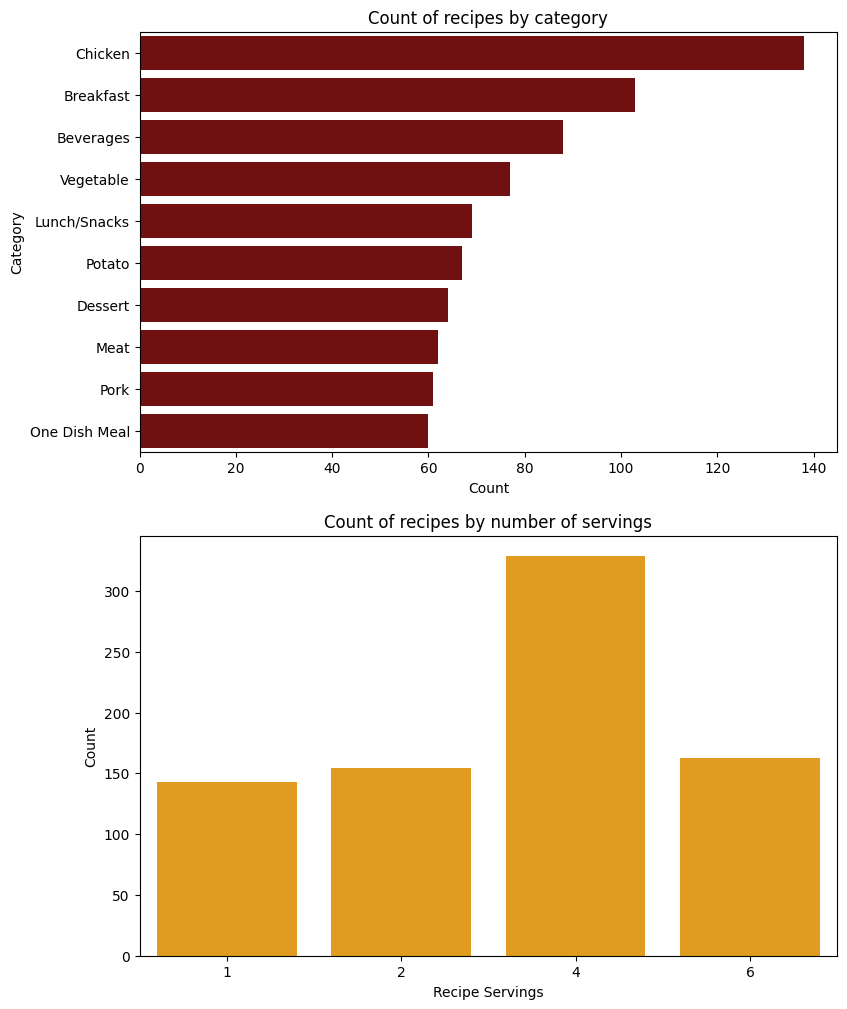

In [37]:
count_by_category = (
    recipes_cleaned.groupby('category')['category']
                   .count()
                   .reset_index(name='count')
                   .sort_values('count', ascending=False)
)

fig, axs = plt.subplots(2, 1, figsize=(9,12))
sns.barplot(data=count_by_category, y='category', x='count', ax=axs[0], color='maroon', orient='h')
axs[0].set_title('Count of recipes by category')
axs[0].set_ylabel('Category')
axs[0].set_xlabel('Count')

sns.countplot(data=recipes_cleaned, x="servings", ax=axs[1], color='orange', order=['1', '2', '4', '6'])
axs[1].set_title('Count of recipes by number of servings')
axs[1].set_ylabel('Count')
axs[1].set_xlabel('Recipe Servings')
plt.subplots_adjust(hspace=0.2)
plt.show()


It looks like chicken is the most popular recipe category, and the most common number of servings a recipe makes is 4.

Next, I will take a look at the high_traffic column. What percent of all recipes led to high website traffic? How does this change based on the recipe category and number of servings?

True     0.583016
False    0.416984
Name: high_traffic, dtype: float64

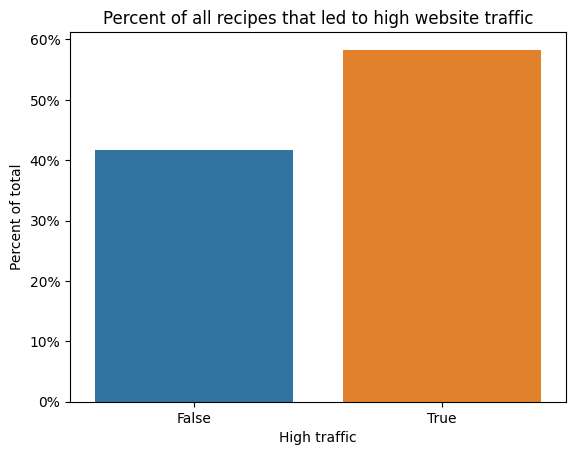

In [38]:
# Investigating what percent of all recipes led to high website traffic in our dataset
normalized_traffic = recipes_cleaned['high_traffic'].value_counts(normalize=True).sort_values(ascending=False)
display(normalized_traffic)
sns.barplot(x=normalized_traffic.index, y=normalized_traffic,  ci=None)
plt.ylabel("Percent of total")
plt.yticks(ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], labels = ['0%', '10%', '20%', '30%', '40%', '50%', '60%'])
plt.xlabel('High traffic')
plt.title('Percent of all recipes that led to high website traffic')
plt.show()

It looks like approximately 58% of recipes in the dataset led to high traffic on the website when posted on the home page. 

How does this differ by category and number of servings?

,category,high_traffic,percentage
18,Vegetable,True,0.987013
16,Potato,True,0.925373
14,Pork,True,0.901639
12,One Dish Meal,True,0.733333
10,Meat,True,0.725806
6,Dessert,True,0.640625
8,Lunch/Snacks,True,0.623188
5,Chicken,True,0.420290
3,Breakfast,True,0.310680
1,Beverages,True,0.045455


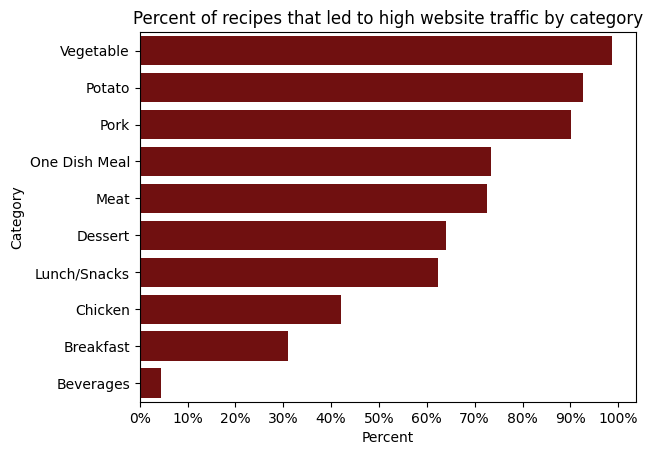

In [39]:
(normalized_traffic_by_category := 
     (recipes_cleaned
      .groupby('category')['high_traffic']
      .value_counts(normalize=True)
      .rename('percentage')
      .reset_index()
      .query('high_traffic')
      .sort_values('percentage', ascending=False)
     )
)
display(normalized_traffic_by_category)
sns.barplot(data=normalized_traffic_by_category, x='percentage', y='category', color='maroon', orient='h')
plt.ylabel('Category')
plt.xlabel('Percent')
plt.xticks(ticks=np.arange(0,1.1,0.1), labels = ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
plt.title('Percent of recipes that led to high website traffic by category')
plt.show()

,category,high_traffic,percentage
18,Vegetable,True,0.987013
16,Potato,True,0.925373
14,Pork,True,0.901639
12,One Dish Meal,True,0.733333
10,Meat,True,0.725806
6,Dessert,True,0.640625
8,Lunch/Snacks,True,0.623188
5,Chicken,True,0.420290
3,Breakfast,True,0.310680
1,Beverages,True,0.045455


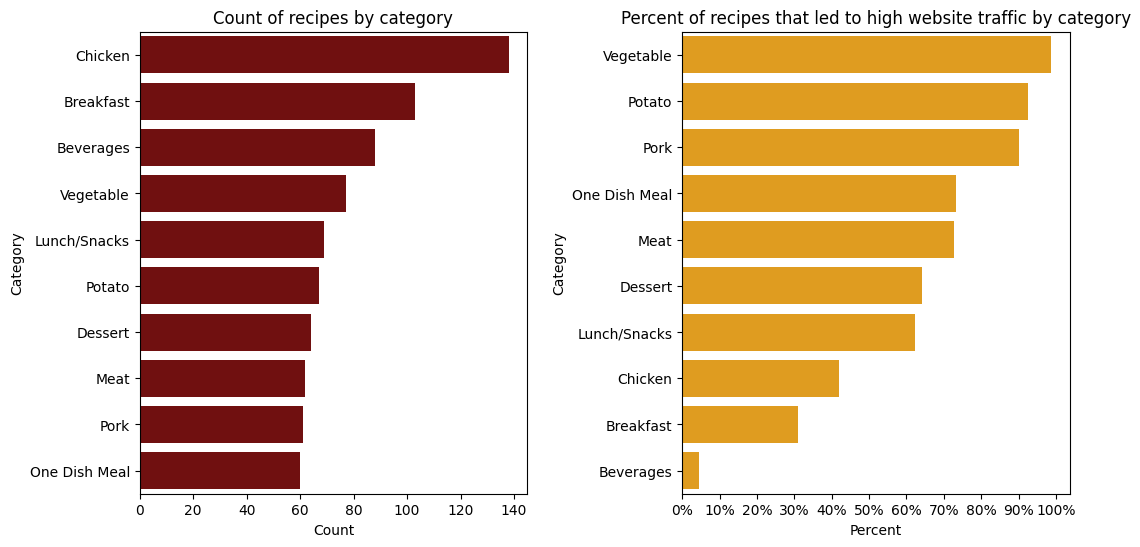

In [40]:
display(normalized_traffic_by_category)
fig, axs = plt.subplots(1, 2, figsize=(12,6))
sns.barplot(data=count_by_category, y='category', x='count', ax=axs[0], color='maroon', orient='h')
axs[0].set_title('Count of recipes by category')
axs[0].set_ylabel('Category')
axs[0].set_xlabel('Count')

sns.barplot(data=normalized_traffic_by_category, y='category', x='percentage', ax=axs[1], color='orange', orient='h')
axs[1].set_title('Percent of recipes that led to high website traffic by category')
axs[1].set_ylabel('Category')
axs[1].set_xlabel('Percent')
axs[1].set_xticks(ticks=np.arange(0,1.1,0.1), labels = ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])

fig.subplots_adjust(wspace=0.4)
plt.show()


According to the above, it looks like recipes in the Vegetable, Potato, and Pork categories are correlated with high traffic. A whopping 98.7% of recipes in the Vegetable category are marked as high-traffic recipes! On the other hand, recipes in the Chicken, Breakfast, and Beverages categories were the least correlated with high traffic. 

I will do the same thing with servings, and see if there is any correlation between the number of servings in a recipe and high website traffic.

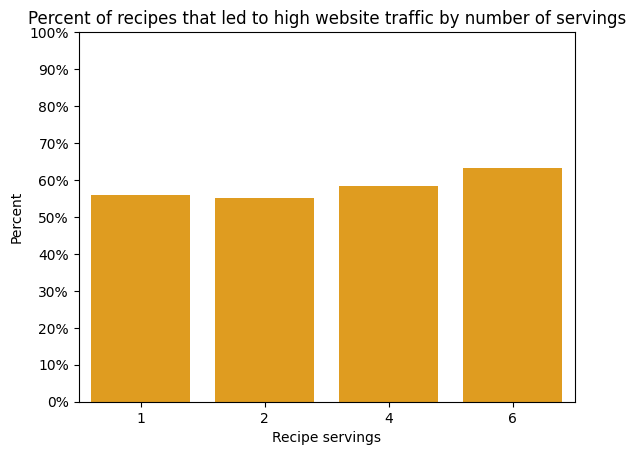

In [41]:
(normalized_traffic_by_servings := 
     (recipes_cleaned
      .groupby('servings')['high_traffic']
      .value_counts(normalize=True)
      .rename('percentage')
      .reset_index()
      .query('high_traffic')
      .sort_values('percentage', ascending=False)
     )
)
sns.barplot(data=normalized_traffic_by_servings, x='servings', y='percentage', color='orange', order=['1', '2', '4', '6'])
plt.ylabel("Percent")
plt.yticks(ticks=np.arange(0,1.1,0.1), labels = ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
plt.xlabel('Recipe servings')
plt.title('Percent of recipes that led to high website traffic by number of servings')
plt.show()

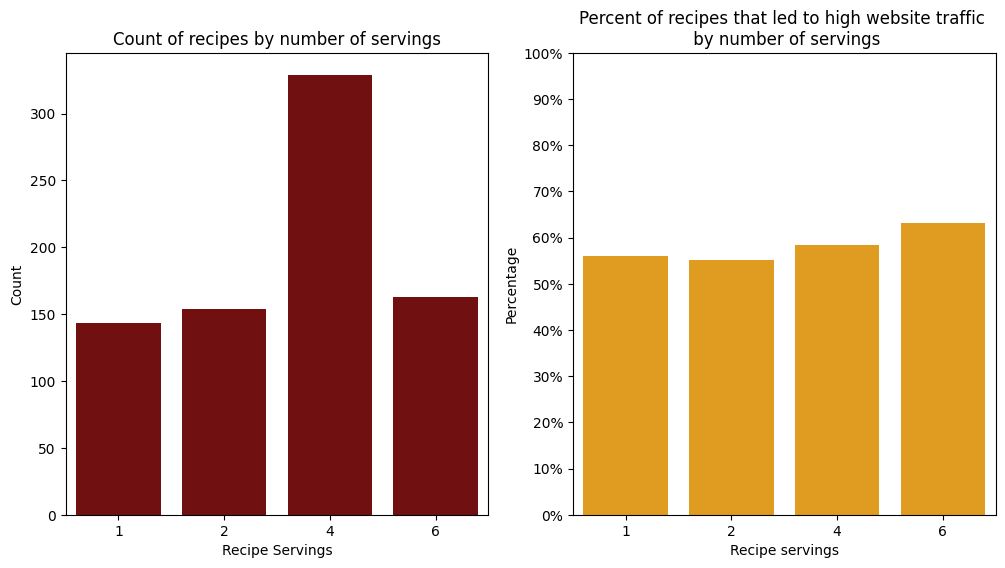

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))

sns.countplot(data=recipes_cleaned, x="servings", ax=axs[0], color='maroon', order=['1', '2', '4', '6'])
axs[0].set_title('Count of recipes by number of servings')
axs[0].set_ylabel('Count')
axs[0].set_xlabel('Recipe Servings')

sns.barplot(data=normalized_traffic_by_servings, x='servings', y='percentage', color='orange', ax=axs[1], order=['1', '2', '4', '6'])
axs[1].set_title('Percent of recipes that led to high website traffic \n by number of servings')
axs[1].set_ylabel("Percentage")
axs[1].set_yticks(ticks=np.arange(0,1.1,0.1), labels = ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
axs[1].set_xlabel('Recipe servings')

plt.subplots_adjust(hspace=0.2)
plt.show()

It looks like there might be a slight positive correlation between number of servings and high website traffic, but it appears quite minimal.

Let's visualize the numeric columns as well, to see if there is any correlation between calories, carbohydrates, sugar, and protein in a recipe, and high website traffic.

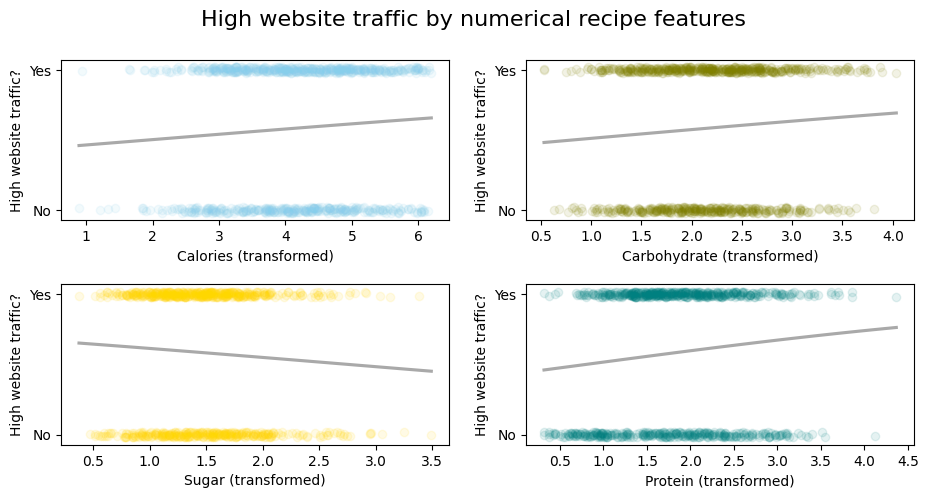

In [43]:
fig, axs = plt.subplots(2, 2, figsize=(11,5))
sns.regplot(data=recipes_cleaned, x='qdrt_calories', y='high_traffic', line_kws={'color': 'darkgray'}, scatter_kws={'color': 'skyblue', 'alpha':0.1}, ax=axs[0, 0], ci=None, logistic=True, y_jitter=0.02)
sns.regplot(data=recipes_cleaned, x='qdrt_carbohydrate', y='high_traffic', line_kws={'color': 'darkgray'}, scatter_kws={'color': 'olive', 'alpha':0.1}, ax=axs[0, 1], ci=None, logistic=True, y_jitter=0.02)
sns.regplot(data=recipes_cleaned, x='qdrt_sugar', y='high_traffic', line_kws={'color': 'darkgray'}, scatter_kws={'color': 'gold', 'alpha':0.1}, ax=axs[1, 0], ci=None, logistic=True, y_jitter=0.02)
sns.regplot(data=recipes_cleaned, x='qdrt_protein', y='high_traffic', line_kws={'color': 'darkgray'}, scatter_kws={'color': 'teal', 'alpha':0.1}, ax=axs[1, 1], ci=None, logistic=True, y_jitter=0.02)
plt.suptitle('High website traffic by numerical recipe features', fontsize=16)
fig.subplots_adjust(hspace=0.4)
axs[0,0].set_yticks(ticks=[0,1], labels = ['No', 'Yes'])
axs[0,1].set_yticks(ticks=[0,1], labels = ['No', 'Yes'])
axs[1,0].set_yticks(ticks=[0,1], labels = ['No', 'Yes'])
axs[1,1].set_yticks(ticks=[0,1], labels = ['No', 'Yes'])
axs[0,0].set_xlabel('Calories (transformed)')
axs[0,1].set_xlabel('Carbohydrate (transformed)')
axs[1,0].set_xlabel('Sugar (transformed)')
axs[1,1].set_xlabel('Protein (transformed)')
axs[0,0].set_ylabel('High website traffic?')
axs[0,1].set_ylabel('High website traffic?')
axs[1,0].set_ylabel('High website traffic?')
axs[1,1].set_ylabel('High website traffic?')
plt.show()


Above we can see that there appears to be slight positive correlations between qdrt_calories and high_traffic, qdrt_carbohydrate and high_traffic, and qdrt_protein and high_traffic. There also appears to be a slight negative correlation between qdrt_sugar and high_traffic. This could suggest that recipes with more calories, more carbohydrates, and more protein tend to lead to high traffic, while recipes with more sugar do not tend to lead to high traffic.

Finally, I will take a look at whether the numerical metrics are correlated with each other using a heat map.

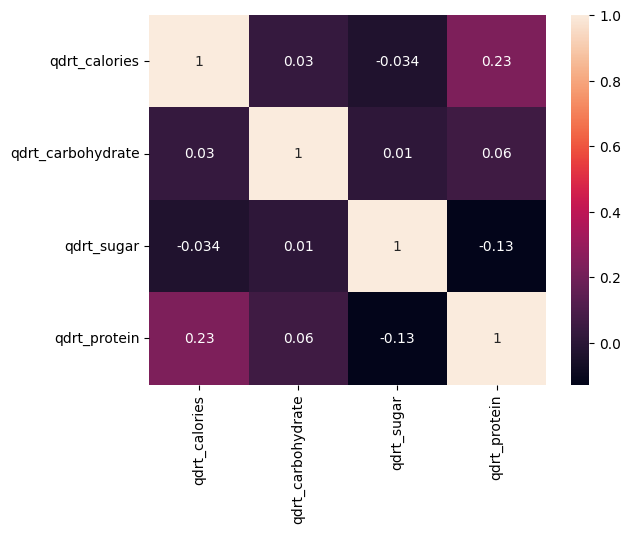

In [44]:
correlation_matrix = recipes_cleaned[['qdrt_calories', 'qdrt_carbohydrate', 'qdrt_sugar', 'qdrt_protein']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In the above heatmap, a correlation score of 1 means perfect correlation, and 0 means no correlation at all. It doesn't look like there are many strong correlations between the above variables. I find this quite interesting as we would probably expect the calorie count of a recipe to increase as its nutritional components, such as sugar, increase. The strongest correlation coefficient we see above is 0.23 between qdrt_protein and qdrt_calories. 

## Fitting and Evaluating Models

Now that we have done some exploratory data analysis, it's time to move onto fitting and evaluating our machine learning models. Tasty Bytes has asked that we build a model that correctly predicts high traffic recipes 80% of the time. In other words, we are looking for an accuracy score of 80% or higher.  

Because the output variable can only take on a value of True (1) or False (0), this is a binary classification problem and can thus be approached through supervised learning. I will be using a logistic regression as my primary classification model, and then will compare to a few other models to find the one with the best accuracy.

First, we need to split the data into training and test sets to avoid data leakage before we start fitting any models.


In [45]:
# Importing necessary libraries for preprocessing data, fitting models, and evaluating models 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Splitting data into training and test sets 
X = recipes_cleaned[['qdrt_calories', 'qdrt_carbohydrate', 'qdrt_sugar', 'qdrt_protein', 'Breakfast', 'Chicken', 'Dessert', 'Lunch/Snacks', 'Meat',  'One_Dish_Meal', 'Pork',  'Potato', 'Vegetable', '2_servings', '4_servings', '6_servings']]
y = recipes_cleaned['high_traffic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

I will also try using StandardScaler() to standardize the numerical data. Standardizing these values makes it easier for machine learning models to learn the relationships between features and the target variable, because the model becomes less sensitive to the scale of the features. In this case, it may not matter much because we already did a quadratic root transformation which brings the numeric variables into similar scales. We will train the models using both the scaled and unscaled data to see which performs better.

In [46]:
# Scale the numerical columns
scaler = StandardScaler()
X_train_num = X_train.loc[:, ['qdrt_calories', 'qdrt_carbohydrate', 'qdrt_sugar', 'qdrt_protein']]
X_test_num = X_test.loc[:, ['qdrt_calories', 'qdrt_carbohydrate', 'qdrt_sugar', 'qdrt_protein']]

X_train_cat = X_train.loc[:, ['Breakfast', 'Chicken', 'Dessert', 'Lunch/Snacks', 'Meat',  'One_Dish_Meal', 'Pork',  'Potato', 'Vegetable', '2_servings', '4_servings', '6_servings']]
X_test_cat = X_test.loc[:, ['Breakfast', 'Chicken', 'Dessert', 'Lunch/Snacks', 'Meat',  'One_Dish_Meal', 'Pork',  'Potato', 'Vegetable', '2_servings', '4_servings', '6_servings']]

X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Concatenate scaled numerical and categorical columns
X_train_scaled = np.concatenate((X_train_cat, X_train_num_scaled), axis=1)
X_test_scaled = np.concatenate((X_test_cat, X_test_num_scaled), axis=1)

### Logistic Regression:

I decided that logistic regression would be an appropriate first model to test because it works well for binary classification problems, where the output variable takes on a value of either 1 or 0. Below, I will train the logistic regression model on both the scaled and unscaled data, and see if there was any benefit to scaling. In addition, I will use Grid Search Cross-Validation to find the best parameters to use for the model. 

In [47]:
# Training logistic regression on unscaled features  
logreg = LogisticRegression()
logreg_unscaled = logreg.fit(X_train, y_train)
y_pred_unscaled = logreg_unscaled.predict(X_test)
unscaled_accuracy = accuracy_score(y_test, y_pred_unscaled)
logreg_unscaled_report=classification_report(y_test, y_pred_unscaled)
print("Logreg unscaled test set accuracy: {}".format(unscaled_accuracy))
print('Logreg unscaled classification report:')
print(logreg_unscaled_report)

# Training logistic regression on scaled features  
logreg = LogisticRegression()
logreg_scaled = logreg.fit(X_train_scaled, y_train)
y_pred_scaled = logreg_scaled.predict(X_test_scaled)
scaled_accuracy = accuracy_score(y_test, y_pred_scaled)
logreg_scaled_report=classification_report(y_test, y_pred_scaled)
print("Logreg scaled test set accuracy: {}".format(scaled_accuracy))
print('Logreg scaled classification report:')
print(logreg_scaled_report)

# Grid Searching logreg parameters using unscaled features
logreg_params = {
    'penalty':[None,'l2'],
    'C':[0, 0.2, 0.4, 0.6, 0.8, 1]
}
kf = KFold(n_splits=5, shuffle=True, random_state=4)
logreg_cv = GridSearchCV(logreg, logreg_params, cv=kf)
logreg_cv.fit(X_train, y_train)
print("Logreg best hyperparameters for unscaled features: {}                                        \
       Logreg cross-validation accuracy score for unscaled features: {}".format(logreg_cv.best_params_, logreg_cv.best_score_))

# Grid Searching logreg parameters using scaled features
logreg_params = {
    'penalty':[None,'l2'],
    'C':[0, 0.2, 0.4, 0.6, 0.8, 1]
}
kf = KFold(n_splits=5, shuffle=True, random_state=4)
logreg_cv = GridSearchCV(logreg, logreg_params, cv=kf)
logreg_cv.fit(X_train_scaled, y_train)
print("Logreg best hyperparameters for scaled features: {}                                        \
       Logreg cross-validation accuracy score for scaled features: {}".format(logreg_cv.best_params_, logreg_cv.best_score_))

Logreg unscaled test set accuracy: 0.7721518987341772
Logreg unscaled classification report:
              precision    recall  f1-score   support

       False       0.67      0.70      0.68        56
        True       0.83      0.81      0.82       102

    accuracy                           0.77       158
   macro avg       0.75      0.76      0.75       158
weighted avg       0.77      0.77      0.77       158

Logreg scaled test set accuracy: 0.7721518987341772
Logreg scaled classification report:
              precision    recall  f1-score   support

       False       0.67      0.70      0.68        56
        True       0.83      0.81      0.82       102

    accuracy                           0.77       158
   macro avg       0.75      0.76      0.75       158
weighted avg       0.77      0.77      0.77       158

Logreg best hyperparameters for unscaled features: {'C': 1, 'penalty': 'l2'}                                               Logreg cross-validation accuracy score fo

Above, we see that our logistic model seems largely indifferent to whether the numerical features are scaled are not, as both the test set scores (77.22%) and cross-validation accuracy scores (74.17%) are identical between models. The test set accuracy score is based on sklearn's accuracy_score, which calculates accuracy as the number of correct predictions divided by the number of total predictions. The CV score is lower than the test set accuracy score because it is an estimate of the model's performance on new, unseen data, which is more conservative and less biased than test set accuracy. 

We can also see some other metrics in the classification report, such as precision, recall, and F1-score. Below, I will summarize the metrics for the unscaled model.
- The precision for the "False" class is 0.67, which means that when the model predicted a sample as "False," it was correct 67% of the time. Similarly, the precision for the "True" class is 0.83, which means that when the model predicted a sample as "True," it was correct 83% of the time.
- The recall for the "False" class is 0.70, which means that out of all the true "False" samples in the test set, the model correctly identified 70% of them. Similarly, the recall for the "True" class is 0.81, which means that out of all the true "True" samples in the test set, the model correctly identified 81% of them.
- F1 score is the harmonic mean of the precision and recall of a model. The F1 score for the "False" class is 0.68, while the F1 score for the "True" class is 0.82. These scores provide an indication of the model's overall performance for each class, taking into account both precision and recall.

I also used GridSearchCV to find the best hyperparameters for the Logistic model, which found that the best parameters were C=1 and penalty=l2 for the unscaled model, and C=0.8 and penalty=l2 for the scaled model.

### Comparison model - K-Nearest Neighbors

I will use K-Nearest Neighbors as my comparison model. K-Nearest Neighbors can perform well on complex binary classification problems, where the decision boundary between the two classes is non-linear. I will run the model using both scaled and unscaled data, and will test to see what number of neighbors performs best for both models.

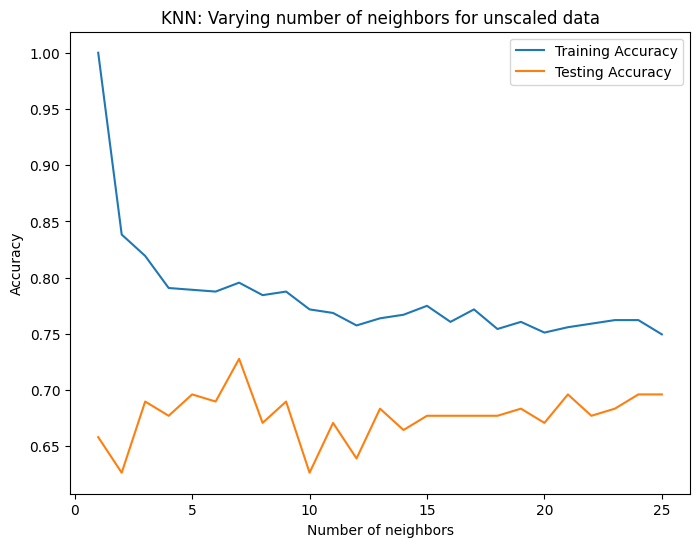

KNN Unscaled Test Set Accuracy: 0.7278481012658228
              precision    recall  f1-score   support

       False       0.60      0.68      0.64        56
        True       0.81      0.75      0.78       102

    accuracy                           0.73       158
   macro avg       0.71      0.72      0.71       158
weighted avg       0.74      0.73      0.73       158

KNN best hyperparameters for unscaled features: {'n_neighbors': 5}                                                             KNN cross-validation accuracy score for unscaled features: 0.7131733533308336


In [48]:
# Using unscaled data

train_accuracies = {}
test_accuracies = {}
neighbors = np.arange(1,26)
for neighbor in neighbors: 
	knn = KNeighborsClassifier(n_neighbors=neighbor)
	knn.fit(X_train, y_train)
	train_accuracies[neighbor] = knn.score(X_train, y_train)
	test_accuracies[neighbor] = knn.score(X_test, y_test)

plt.figure(figsize=(8,6))
plt.title("KNN: Varying number of neighbors for unscaled data")
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.show()

# Based on the graph, the best number of neighbors for the test set is 7
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
knn_pred_unscaled = knn.predict(X_test)
knn_accuracy_unscaled = accuracy_score(knn_pred_unscaled, y_test)
print("KNN Unscaled Test Set Accuracy: {}".format(knn_accuracy_unscaled))
knn_unscaled_report=classification_report(y_test, knn_pred_unscaled)
print(knn_unscaled_report)

# Cross-validation score for unscaled features
knn_params = {'n_neighbors':np.arange(1, 26)}
kf = KFold(n_splits=5, shuffle=True, random_state=4)
knn_cv = GridSearchCV(knn, knn_params, cv=kf)
knn_cv.fit(X_train, y_train)
print("KNN best hyperparameters for unscaled features: {}                                                      \
       KNN cross-validation accuracy score for unscaled features: {}".format(knn_cv.best_params_, knn_cv.best_score_))

Our KNN model using unscaled data has an accuracy score of 72.78% on the test set, and a cross-validation accuracy score of 71.32%, both of which are worse than the logistic model. 

Note that while the above states that the best hyperparameters for the unscaled model is n_neighbors=5, we can tell by the graph that for this particular test set, the best number of neighbors is n_neighbors=7. 

The classification report gives us some additional insight: 
- The precision for the "False" class is 0.60, which means that when the model predicted a sample as "False," it was correct 60% of the time. Similarly, the precision for the "True" class is 0.81, which means that when the model predicted a sample as "True," it was correct 81% of the time.
- The recall for the "False" class is 0.68, which means that out of all the true "False" samples in the test set, the model correctly identified 68% of them. Similarly, the recall for the "True" class is 0.75, which means that out of all the true "True" samples in the test set, the model correctly identified 75% of them.
- F1 score is the harmonic mean of the precision and recall of a model. The F1 score for the "False" class is 0.64, while the F1 score for the "True" class is 0.78. These scores provide an indication of the model's overall performance for each class, taking into account both precision and recall.

Repeating the same process with scaled data:

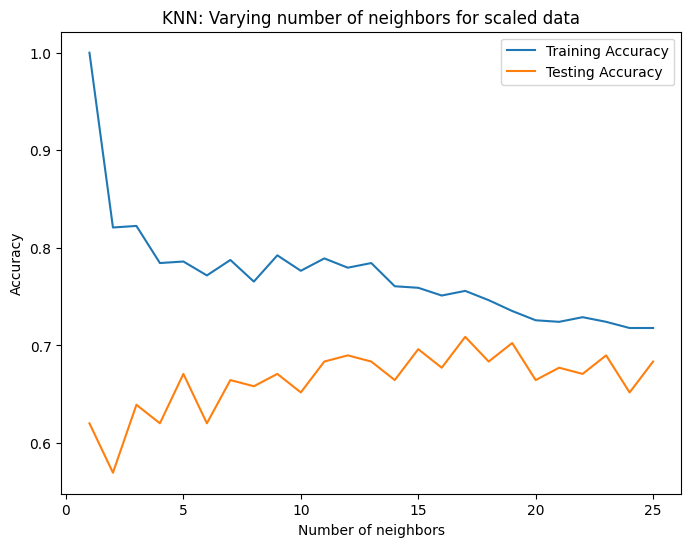

KNN Scaled Test Set Accuracy: 0.7088607594936709
              precision    recall  f1-score   support

       False       0.58      0.62      0.60        56
        True       0.79      0.75      0.77       102

    accuracy                           0.71       158
   macro avg       0.68      0.69      0.69       158
weighted avg       0.71      0.71      0.71       158

KNN best hyperparameters for scaled features: {'n_neighbors': 11}                                                          KNN cross-validation accuracy score for scaled features: 0.6940382452193475


In [49]:
# Using scaled data

train_accuracies = {}
test_accuracies = {}
neighbors = np.arange(1,26)
for neighbor in neighbors: 
	knn = KNeighborsClassifier(n_neighbors=neighbor)
	knn.fit(X_train_scaled, y_train)
	train_accuracies[neighbor] = knn.score(X_train_scaled, y_train)
	test_accuracies[neighbor] = knn.score(X_test_scaled, y_test)

plt.figure(figsize=(8,6))
plt.title("KNN: Varying number of neighbors for scaled data")
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.show()

# Looks like 17 neighbors is the best option for this test set
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train_scaled, y_train)
knn_pred_scaled = knn.predict(X_test_scaled)
knn_accuracy_scaled = accuracy_score(knn_pred_scaled, y_test)
print("KNN Scaled Test Set Accuracy: {}".format(knn_accuracy_scaled))
knn_scaled_report=classification_report(y_test, knn_pred_scaled)
print(knn_scaled_report)

# Cross-validation score for unscaled features
knn_params = {'n_neighbors':np.arange(1, 26)}
kf = KFold(n_splits=5, shuffle=True, random_state=4)
knn_cv = GridSearchCV(knn, knn_params, cv=kf)
knn_cv.fit(X_train_scaled, y_train)
print("KNN best hyperparameters for scaled features: {}                                                   \
       KNN cross-validation accuracy score for scaled features: {}".format(knn_cv.best_params_, knn_cv.best_score_))

Our KNN model using scaled data has an accuracy score of 70.89%, and a cross-validation accuracy score of 69.40%, both of which are worse than the logistic model.

Note that while the above states that the best hyperparameters for the unscaled model is n_neighbors=11, we can tell by the graph that for this particular test set, the best number of neighbors is n_neighbors=17. 

The classification report gives us some additional insight: 
- The precision for the "False" class is 0.58, which means that when the model predicted a sample as "False," it was correct 58% of the time. Similarly, the precision for the "True" class is 0.79, which means that when the model predicted a sample as "True," it was correct 79% of the time.
- The recall for the "False" class is 0.62, which means that out of all the true "False" samples in the test set, the model correctly identified 62% of them. Similarly, the recall for the "True" class is 0.75, which means that out of all the true "True" samples in the test set, the model correctly identified 75% of them.
- F1 score is the harmonic mean of the precision and recall of a model. The F1 score for the "False" class is 0.60, while the F1 score for the "True" class is 0.77. These scores provide an indication of the model's overall performance for each class, taking into account both precision and recall.

We see that the unscaled model produces slightly better metrics for k-nearest neighbors, so going forward we will just use the unscaled data for simplicity.

So far, our logistic model is still the best performing, although it is not at 80% accuracy. Below, I will test some additional models that are good for classification problems, and see if any of them perform better than the logistic model. 

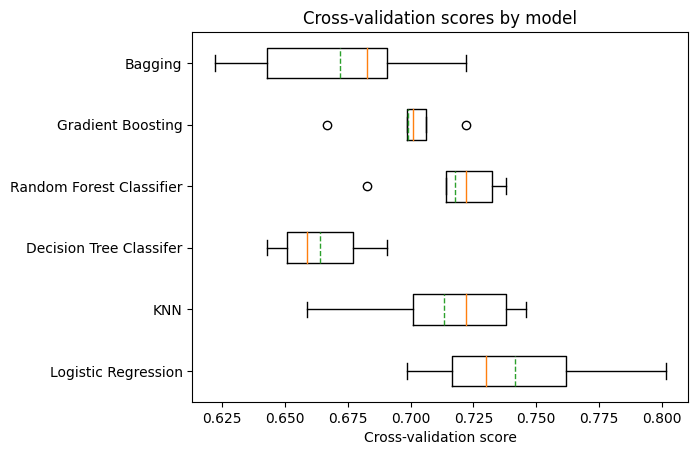

Logistic Regression Test Set Accuracy: 0.7721518987341772
KNN Test Set Accuracy: 0.6962025316455697
Decision Tree Classifer Test Set Accuracy: 0.6835443037974683
Random Forest Classifier Test Set Accuracy: 0.7025316455696202
Gradient Boosting Test Set Accuracy: 0.7151898734177216
Bagging Test Set Accuracy: 0.6708860759493671


In [50]:
np.random.seed(4)
models ={"Logistic Regression": LogisticRegression(), "KNN": KNeighborsClassifier(),"Decision Tree Classifer": DecisionTreeClassifier(), "Random Forest Classifier": RandomForestClassifier(), "Gradient Boosting": GradientBoostingClassifier(), "Bagging": BaggingClassifier()}
results = []
for model in models.values():
	kf = KFold(n_splits=5, random_state=4, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kf) 
	results.append(cv_results)
plt.boxplot(results, labels=models.keys(), meanline=True, showmeans=True, vert=False)
plt.title('Cross-validation scores by model')
plt.xlabel('Cross-validation score')
plt.show()

#test set performance 
for name, model in models.items(): 
	model.fit(X_train, y_train)
	test_score = model.score(X_test, y_test)
	print("{} Test Set Accuracy: {}".format(name, test_score))

It looks like the Logistic regression is still our best performing model, based on both the cross-validation box plot and the test set accuracy score. One last thing to try is a voting classifier to see if combining the best models of the above will lead to an even better model. I will take the three models with the highest mean CV scores - Logistic, K-nearest neighbors, and Random Forest. 

Logistic Regression : 0.772
KNN : 0.696
Random Forest Classifier : 0.715
Voting Classifier: 0.740506329113924


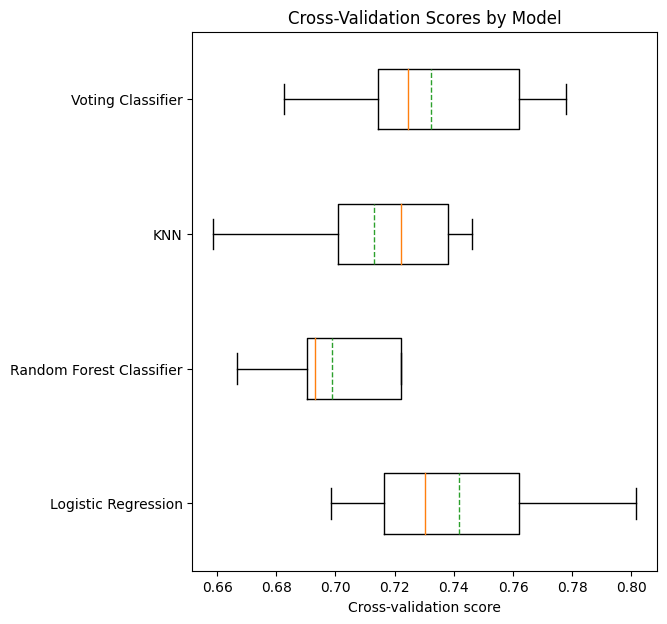

In [51]:
from sklearn.ensemble import VotingClassifier
SEED = 4
lr = LogisticRegression(random_state=SEED)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=SEED)
classifiers = [('Logistic Regression', lr), ('KNN', knn),('Random Forest Classifier', rf)]

for clf_name, clf in classifiers: 
	clf.fit(X_train, y_train)
	y_pred = clf.predict(X_test)
	print('{:s} : {:.3f}'.format(clf_name, accuracy_score(y_test, y_pred)))

vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train, y_train)
vc_pred_unscaled = vc.predict(X_test)
print('Voting Classifier: {}'.format(accuracy_score(y_test, vc_pred_unscaled)))

models ={"Logistic Regression": LogisticRegression(), "Random Forest Classifier": RandomForestClassifier(), "KNN": KNeighborsClassifier(), 'Voting Classifier': VotingClassifier(estimators=classifiers)}
results = []
for model in models.values():
	kf = KFold(n_splits=5, random_state=4, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kf) 
	results.append(cv_results)
plt.figure(figsize=(6, 7))
plt.boxplot(results, labels=models.keys(), meanline=True, showmeans=True, vert=False)
plt.title('Cross-Validation Scores by Model')
plt.xlabel('Cross-validation score')
plt.show()

It looks like the logistic regression still outperforms the voting classifier in the test set, with a 77.2% accuracy as compared to a 74.05% accuracy. In the box plot, we can see that the logistic regression's mean and median CV scores are both higher than the voting classifer. Let's take a closer look at the test set statistics for the logistic, KNN, and voting classifier models.

In [52]:
print("Logistic regression classification report:")                
print(logreg_unscaled_report)
print("K-nearest neighbors classification report:")   
print(knn_unscaled_report)
print("Voting classifier classification report:")
voting_unscaled_report = classification_report(y_test, vc_pred_unscaled)
print(voting_unscaled_report)

Logistic regression classification report:
              precision    recall  f1-score   support

       False       0.67      0.70      0.68        56
        True       0.83      0.81      0.82       102

    accuracy                           0.77       158
   macro avg       0.75      0.76      0.75       158
weighted avg       0.77      0.77      0.77       158

K-nearest neighbors classification report:
              precision    recall  f1-score   support

       False       0.60      0.68      0.64        56
        True       0.81      0.75      0.78       102

    accuracy                           0.73       158
   macro avg       0.71      0.72      0.71       158
weighted avg       0.74      0.73      0.73       158

Voting classifier classification report:
              precision    recall  f1-score   support

       False       0.63      0.64      0.64        56
        True       0.80      0.79      0.80       102

    accuracy                           0.74       158
 

The above classification reports show that the logistic regression outperforms the voting classifier for accuracy, precision, and recall, making it the best model overall that we have tested. While we were not able to achieve an accuracy score of 80%, we were able to achieve 77%, which is pretty close. In addition, the classification report shows that the logistic model has precision and recall scores above 80% for the "True" class. 

Finally, I will take a look at the coefficients for the model to see if we can discern the recipe features that are most correlated with high traffic. 

In [53]:
# Get feature names from X
feature_names = X.columns

# Print the coefficients with the feature names
for feature_name, coef in zip(feature_names, logreg_unscaled.coef_[0]):
    print(f"{feature_name}: {coef:.2f}")

qdrt_calories: 0.10
qdrt_carbohydrate: 0.05
qdrt_sugar: -0.10
qdrt_protein: 0.30
Breakfast: -0.11
Chicken: 0.13
Dessert: 1.20
Lunch/Snacks: 1.12
Meat: 1.39
One_Dish_Meal: 1.50
Pork: 2.50
Potato: 2.59
Vegetable: 3.70
2_servings: -0.36
4_servings: -0.26
6_servings: 0.21


For the quadratic root transformed features (qdrt_calories, qdrt_carbohydrate, qdrt_sugar, and qdrt_protein), the coefficients represent the change in the log odds of the target variable for a one-unit change in the quadratic root of the corresponding variable. For example, a coefficient of 0.10 for qdrt_calories means that a one-unit increase in the quadratic root of calories is associated with an increase in the log odds of high_traffic by 0.10 units, holding all other features constant.

For the binary features (Breakfast onwards), the coefficients represent the change in the log odds of the target variable for a change from 0 to 1 in the corresponding feature. Remember that 0 in this case actually signifies when the category is equal to 'Beverage', because we created k-1 dummy variables for the 'Category' feature. For example, a coefficient of -0.11 for Breakfast means that the log odds of high_traffic decreases by 0.11 for a recipe that is labeled as 'Breakfast' as opposed to a recipe that is labeled as 'Beverage', holding all other features constant.

Because numerical and binary features are on different scales and units, we cannot directly compare them to one another. However, we can compare binary feature coefficients with each other, and use the sign of the numeric feature coefficients to help us understand whether an increase in those features increases or decreases the log odds ratios of high_traffic. 

Within the category features, we see that the features with the largest positive effect on the log odds ratio are 'Vegetable' (coefficient = 3.70), 'Potato' (coefficient = 2.59), and 'Pork' (coefficient = 2.50), while the features with the smallest effect on the log odds ratio are 'Breakfast' (coefficient = -0.11), 'Beverage', and 'Chicken' (coefficient = 0.13). Note that the absent category, 'Beverage', is associated with the second lowest traffic as it is between 'Breakfast' with the only negative coefficient and 'Chicken' with the smallest positive coefficient. This tells us that recipes labeled as 'Vegetable', 'Potato', or 'Pork' are the most popular, while recipes labeled as 'Beverage', 'Breakfast', and 'Chicken' are the least popular. The business should consider posting recipes in the high traffic categories and avoid posting recipes in the low traffic categories in order to increase website traffic. 

Within the number of servings features, we can see that recipes that make 2 and 4 servings decrease the log odds of high_traffic as opposed to a recipe that makes 1 serving, holding all else constant. A recipe that makes 6 servings increases the log odds of high_traffic as opposed to a recipe that makes 1 serving, holding all else constant. These coefficients don't appear to be very large, especially compared to the other categorical features, so I would not recommend that the business focus too much on a recipe's number of servings to increase website traffic.

The numeric feature coefficients tell us that an increase in the quadratic root of calories, carbohydrate, and protein have a positive effect on the log odds ratio, with protein having the largest positive coeffient. We also see that an increase in the quadratic root of sugar has a negative effect on the log odds ratio. Thus, the business should focus on posting recipes to the home page that are high in protein and low in sugar in order to increase website traffic.

In summary, we were able to build a logistic model on the recipe data that has an accuracy score of 77.2% on the test set data, and a more conservative mean cross-validation score of 74.17% which is a proxy for how the model might perform on new, unseen data. While this is short of the 80% target that was requested by the Product Manager, there are still some strategies that we can employ going forward to improve the model and both of these metrics. 
1) Collecting more data that can be used to train the model - more data will give the model more training instances and thus increase accuracy metrics
2) Working with the product manager who created the data to understand how exactly the data was sourced, with the hope to identify erroneous values and correct them instead of dropping the entire instance
3) Further in-depth testing of different machine learning algorithms, with additional focus on pre-processing and hyperparameter tuning to improve model performance